# Initialize

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
    import tensorflow.compat.v2 as tf
    tf.enable_v2_behavior()
    assert tf2.enabled()

import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input

from tensorflow.keras.layers import Dense, InputLayer
import tensorflow_probability as tfp
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
%matplotlib inline
from imblearn.over_sampling import ADASYN
import seaborn as sns
from xgboost import XGBClassifier
np.random.seed(0)
tf.random.set_seed(0)
random_state = 42
print(tf.__version__)
print(tfp.__version__)

2.7.0
0.14.1


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Helper Functions

In [3]:

def find_best_threshold(true, pred_scores, metric = metrics.f1_score):
    step = (max(pred_scores) - min(pred_scores)) /100
    cur_threshold = 0
    best_threshold = 0
    best_score = 0
    while cur_threshold < max(pred_scores) :
        # print( cur_threshold,max(pred_scores) )
        cur_score = metric(true, pred_scores > cur_threshold)
        if cur_score > best_score:
            best_score = cur_score
            best_threshold = cur_threshold
        cur_threshold += step
        # print(f"Max Pred Score: {max(pred_scores)}")
        # print(f"Best Threshold: {best_threshold}")
        # print(f"Current Threshold: {cur_threshold}")
        # print(f"Best score: {best_score}")
        # print(f"Current score: {cur_score}")
    return best_threshold
def get_res(true, pred_scores, threshold, name = ""):
    metrics_dict = {"F1":lambda x, y : metrics.f1_score(x, y > threshold),
               "AUC": metrics.roc_auc_score,
               "AUC PRC": metrics.average_precision_score
               }
    res = pd.Series()
    res.name = name
    for name, metric in metrics_dict.items():
        res[name] = metric(true, pred_scores)
    return res

In [4]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

from sklearn.metrics import precision_recall_curve, average_precision_score, auc
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

    if returnPreds==True:
        return preds

### Results holders

In [5]:
class results_holder:
    def __init__(self, train_true, val_true, train_val_true, test_true):
        self.train_res = pd.DataFrame()
        self.val_res = pd.DataFrame()
        self.test_res = pd.DataFrame()
        self.train_true = train_true
        self.train_val_true = train_val_true
        self.val_true = val_true
        self.test_true = test_true
    def add_results(self, train, val, train_val, test, name = ""):
        train_threshold = find_best_threshold(self.train_true, train)
        val_threshold = find_best_threshold(self.val_true, val)
        train_val_threshold = find_best_threshold(self.train_val_true, train_val)
        
        train_res = get_res(self.train_true, train, train_threshold, name)
        val_res = get_res(self.val_true, val, val_threshold, name)
        # Threshold on train_val
        test_res = get_res(self.test_true, test, train_val_threshold, name)

        self.train_res = self.train_res.append(train_res)
        self.val_res = self.val_res.append(val_res)
        self.test_res = self.test_res.append(test_res)



## Import and Process Data

In [58]:
input_path = "/gdrive/MyDrive/BT4012 Project"
raw = pd.read_csv(f"{input_path}/creditcard.csv").sample(100000, random_state = random_state)
X_train, X_test, y_train, y_test = train_test_split(raw.drop("Class", axis = 1), raw["Class"], test_size=0.25, random_state = random_state)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state = random_state)
[x.shape for x in [X_train, X_val, X_test, y_train, y_val, y_test]]




[(75000, 30), (12500, 30), (12500, 30), (75000,), (12500,), (12500,)]

In [59]:
time_to_hours = lambda x : x / 3600 % 24
log_scale = lambda x : np.log(x+1) # Prevent inf

def preprocessing(data):
    data = data.copy()
    data["Time"] = data["Time"].apply(time_to_hours)
    data["Amount"] = data["Amount"].apply(log_scale)
    return data
X_train_cleaned = preprocessing(X_train)
X_val_cleaned = preprocessing(X_val)
X_test_cleaned = preprocessing(X_test)
X_train_cleaned.shape, X_val_cleaned.shape, X_test_cleaned.shape

((75000, 30), (12500, 30), (12500, 30))

In [60]:
X_train_val_cleaned = pd.concat([X_train_cleaned, X_val_cleaned], axis = 0)
y_train_val = pd.concat([y_train, y_val], axis = 0)

all_results = results_holder(y_train, y_val, y_train_val, y_test)

X_train_val_cleaned.shape, y_train_val.shape

((87500, 30), (87500,))

In [61]:
X_train_cleaned.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
134495,22.453611,-1.472397,0.342064,1.475451,0.058871,1.154972,0.788022,0.548575,0.332188,-0.395896,-0.598640,0.728040,0.637057,0.248511,0.152280,1.460489,-1.051531,0.539399,-2.175693,-2.467226,-0.590383,0.125903,0.773880,0.520450,-0.656679,-0.295381,-0.509949,0.089405,0.016172,2.707383
238733,17.610278,-0.537673,1.305584,-0.216030,-0.362919,0.102158,-1.073609,0.913679,-0.052749,-0.384988,-0.617919,-0.877046,0.569788,1.042128,0.468495,0.423610,-0.337881,-0.360529,0.111845,0.081928,-0.230769,0.476727,1.357714,-0.163708,0.117701,-0.446789,-0.189386,-0.149430,0.142881,3.680595
69992,14.906389,1.204744,0.332036,0.419879,1.204284,-0.456784,-1.156401,0.222527,-0.244576,-0.009082,0.016706,-0.136917,0.185274,-0.267222,0.452310,0.919730,-0.035420,-0.295170,-0.230926,-0.495037,-0.150596,0.051702,0.165180,-0.063627,0.718796,0.633879,-0.348841,0.011193,0.024707,2.630449
282022,23.390278,-4.304655,0.556812,1.907029,5.124435,-0.237664,2.369248,-4.414476,-8.339140,-1.639420,0.075057,-1.480551,-0.117490,-0.452826,0.588899,1.178412,1.214333,0.320657,0.955402,0.763382,0.233238,-3.383596,2.031254,2.013425,0.012022,0.220624,0.639576,0.824547,-0.269609,2.257588
269030,21.416111,1.845828,0.359027,-1.222742,3.724936,0.694074,0.027421,0.403851,-0.034137,-0.852703,1.485295,-1.603370,-1.261210,-1.937668,0.765001,-0.734385,0.655008,-0.541928,-0.556410,-1.352393,-0.285169,-0.114363,-0.542256,0.207178,0.504820,-0.050089,-0.159089,-0.078525,-0.041816,4.152771


In [62]:
X_train_cleaned_0s = X_train_cleaned[y_train == 0]
X_val_cleaned_0s = X_val_cleaned[y_val == 0]
X_train_val_cleaned_0s = X_train_val_cleaned[y_train_val== 0]


In [63]:
# x = X_train_cleaned
# y = y_train

# x_norm, x_fraud = x.values[y == 0], x.values[y == 1]

# x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]
# x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample, test_size=0.2, random_state = 42)

# tf_train = tf.data.Dataset.from_tensor_slices((x_norm_train_sample, x_norm_train_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))
# tf_val = tf.data.Dataset.from_tensor_slices((x_norm_val_sample, x_norm_val_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

# Principal Component Analysis (PCA)

References:
https://www.oreilly.com/library/view/hands-on-unsupervised-learning/9781492035633/ch04.html

Note: PCA has already been applied on the dataset before this. Applying PCA again is redundant, but the reference tutorial which uses the same dataset mentions that it is ok to apply PCA twice. We will just assume that the features given are the original features. 

In [65]:
n_components = 30

pca = PCA(n_components=n_components, random_state=random_state)

# Fit only on non-anomalies
pca.fit(X_train_cleaned_0s)

def get_PCA_anomaly_Scores(data, pca):
    # Decomposition
    data_PCA = pca.transform(data)
    # Reconstruction 
    data_PCA_inverse = pca.inverse_transform(data_PCA)
    data_PCA_inverse = pd.DataFrame(data=data_PCA_inverse, index=data.index)
    return anomalyScores(data, data_PCA_inverse)

In [66]:
X_train_PCA_scores = get_PCA_anomaly_Scores(X_train_cleaned, pca)
X_val_PCA_scores = get_PCA_anomaly_Scores(X_val_cleaned, pca)
pca.fit(X_train_val_cleaned_0s)
X_train_val_PCA_scores = get_PCA_anomaly_Scores(X_train_val_cleaned, pca)
X_test_PCA_scores = get_PCA_anomaly_Scores(X_test_cleaned, pca)

In [67]:
all_results.add_results(X_train_PCA_scores, X_val_PCA_scores, X_train_val_PCA_scores, X_test_PCA_scores, "PCA" )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [68]:
all_results.train_res

,AUC,AUC PRC,F1
PCA,0.947501,0.189318,0.352941


In [69]:
all_results.val_res

,AUC,AUC PRC,F1
PCA,0.955023,0.206501,0.45


In [70]:
all_results.test_res

,AUC,AUC PRC,F1
PCA,0.97345,0.171445,0.16


# Kernel PCA (kPCA) (Untestable due to memory issues)

We were unable to test kernel PCA as we could not allocate enough memory for the process



In [18]:
# from sklearn.decomposition import KernelPCA
# n_components = 30

# kpca = KernelPCA(kernel = "rbf", #gaussian kernel
#                  n_components=n_components, 
#                  random_state=random_state, copy_X=False, fit_inverse_transform=True) 

# # Fit only on non-anomalies
# kpca.fit(X_train_cleaned_0s)

# # Decomposition
# X_train_cleaned_kPCA = pd.DataFrame(data=X_train_cleaned, index=X_train.index)

# # Reconstruction 
# X_train_cleaned_kPCA_inverse = pca.inverse_transform(X_train_cleaned_kPCA)
# X_train_cleaned_kPCA_inverse = pd.DataFrame(data=X_train_cleaned_kPCA_inverse,
#                                    index=X_train.index)

# def get_kPCA_anomaly_Scores(data, kpca):
#     # Decomposition
#     data_cleaned_kPCA = pd.DataFrame(data=data, index=data.index)

#     # Reconstruction 
#     data_cleaned_kPCA_inverse = kpca.inverse_transform(data_cleaned_kPCA)
#     data_cleaned_kPCA_inverse = pd.DataFrame(data=data_cleaned_kPCA_inverse,
#                                    index=data.index)

#     return anomalyScores(data, data_cleaned_kPCA_inverse)


In [19]:
# X_train_kPCA_scores = get_kPCA_anomaly_Scores(X_train_cleaned, kpca)
# X_val_kPCA_scores = get_kPCA_anomaly_Scores(X_val_cleaned, kpca)
# kpca.fit(X_train_val_cleaned_0s)
# X_train_val_kPCA_scores = get_kPCA_anomaly_Scores(X_train_val_cleaned, kpca)
# X_test_kPCA_scores = get_kPCA_anomaly_Scores(X_test_cleaned, kpca)

# all_results.add_results(X_train_kPCA_scores, X_val_kPCA_scores, X_train_val_kPCA_scores, X_test_kPCA_scores, "kPCA" )

In [20]:
# all_results.train_res

In [21]:
# all_results.val_res

In [22]:
# all_results.test_res

# AutoEncoder (AE)

References: 
BT4012 Tutorial Codes

In [23]:
input_shape = 30
encoding_dim  = 2
intermediary_dims = [25, 20, 15, 10]
batch_size = 128
max_epochs = 1000
activation = "relu"

input_layer = Input(shape=(input_shape,))
encoded = Dense(16, activation=activation)(input_layer)
encoded = Dense(8, activation=activation)(encoded)
encoded = Dense(4, activation=activation)(encoded)

# bottleneck layer
encoded = Dense(encoding_dim, activation=activation)(encoded)

decoded = Dense(4, activation=activation)(encoded)
decoded = Dense(8, activation=activation)(decoded)
decoded = Dense(16, activation=activation)(decoded)
decoded = Dense(input_shape)(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)
decoder_layer1, decoder_layer2, decoder_layer3, decoder_layer4 = \
        autoencoder.layers[-1], autoencoder.layers[-2], autoencoder.layers[-3], autoencoder.layers[-4]


encoded_input = Input(shape=(encoding_dim,))
# create the decoder model
decoder = Model(encoded_input, decoder_layer1(decoder_layer2(decoder_layer3(decoder_layer4(encoded_input)))))


autoencoder.compile(optimizer=tf.keras.optimizers.Nadam(), 
            loss="mse")
encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 16)                496       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                                 
Total params: 678
Trainable params: 678
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
____________________________________________

In [24]:
checkpointer = ModelCheckpoint(filepath='AE_train_bestmodel.h5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
hist = autoencoder.fit(X_train_cleaned_0s, X_train_cleaned_0s,
               epochs=max_epochs,
               shuffle=True,
               verbose=1,
               validation_data= (X_val_cleaned_0s, X_val_cleaned_0s),
               callbacks=[checkpointer, earlystopper, reduceLR])

autoencoder_train = autoencoder

Epoch 1/1000
2340/2340 [==============================] - 19s 7ms/step - loss: 1.2512 - val_loss: 0.8851 - lr: 0.0010
Epoch 2/1000
2340/2340 [==============================] - 17s 7ms/step - loss: 0.8617 - val_loss: 0.8364 - lr: 0.0010
Epoch 3/1000
2340/2340 [==============================] - 18s 8ms/step - loss: 0.8246 - val_loss: 0.8011 - lr: 0.0010
Epoch 4/1000
2340/2340 [==============================] - 17s 7ms/step - loss: 0.8012 - val_loss: 0.7769 - lr: 0.0010
Epoch 5/1000
2340/2340 [==============================] - 16s 7ms/step - loss: 0.7786 - val_loss: 0.7606 - lr: 0.0010
Epoch 6/1000
2340/2340 [==============================] - 17s 7ms/step - loss: 0.7650 - val_loss: 0.7479 - lr: 0.0010
Epoch 7/1000
2340/2340 [==============================] - 17s 7ms/step - loss: 0.7569 - val_loss: 0.7419 - lr: 0.0010
Epoch 8/1000
2340/2340 [==============================] - 17s 7ms/step - loss: 0.7518 - val_loss: 0.7401 - lr: 0.0010
Epoch 9/1000
2340/2340 [==============================] 

In [25]:
checkpointer = ModelCheckpoint(filepath='AE_train_val_bestmodel.h5', verbose=0, save_best_only=True, monitor='loss')
earlystopper = EarlyStopping(monitor='loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)
reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.0001)

hist = autoencoder.fit(X_train_val_cleaned_0s, X_train_val_cleaned_0s,
               epochs=max_epochs,
               shuffle=True,
               verbose=1,
               callbacks=[checkpointer, earlystopper, reduceLR])

autoencoder_train_val = autoencoder

Epoch 1/1000
2730/2730 [==============================] - 20s 7ms/step - loss: 0.7017 - lr: 1.0000e-04
Epoch 2/1000
2730/2730 [==============================] - 19s 7ms/step - loss: 0.7009 - lr: 1.0000e-04
Epoch 3/1000
2730/2730 [==============================] - 19s 7ms/step - loss: 0.7006 - lr: 1.0000e-04
Epoch 4/1000
2730/2730 [==============================] - 19s 7ms/step - loss: 0.7003 - lr: 1.0000e-04
Epoch 5/1000
2730/2730 [==============================] - 18s 7ms/step - loss: 0.7003 - lr: 1.0000e-04
Epoch 6/1000
2730/2730 [==============================] - 19s 7ms/step - loss: 0.7001 - lr: 1.0000e-04
Epoch 7/1000
2730/2730 [==============================] - 18s 7ms/step - loss: 0.7002 - lr: 1.0000e-04
Epoch 8/1000
2730/2730 [==============================] - 18s 6ms/step - loss: 0.7002 - lr: 1.0000e-04
Epoch 9/1000
2730/2730 [==============================] - 18s 7ms/step - loss: 0.6991 - lr: 1.0000e-04
Epoch 10/1000
2730/2730 [==============================] - 18s 7ms/step -

In [71]:
AE_X_train = autoencoder_train(X_train_cleaned.values)
AE_X_val = autoencoder_train(X_val_cleaned.values)
AE_X_train_val = autoencoder_train_val(X_train_val_cleaned.values)
AE_X_test = autoencoder_train_val(X_test_cleaned.values)
AE_train_scores = anomalyScores(X_train_cleaned, AE_X_train)
AE_val_scores = anomalyScores(X_val_cleaned, AE_X_val)
AE_train_val_scores = anomalyScores(X_train_val_cleaned, AE_X_train_val)
AE_test_scores = anomalyScores(X_test_cleaned, AE_X_test)


all_results.add_results(AE_train_scores, AE_val_scores, AE_train_val_scores, AE_test_scores, "AE" )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [72]:
all_results.train_res

,AUC,AUC PRC,F1
PCA,0.947501,0.189318,0.352941
AE,0.956983,0.380441,0.404181


In [73]:
all_results.val_res

,AUC,AUC PRC,F1
PCA,0.955023,0.206501,0.450000
AE,0.968501,0.360957,0.514286


In [74]:
all_results.test_res

,AUC,AUC PRC,F1
PCA,0.973450,0.171445,0.160000
AE,0.977295,0.426893,0.380952


# Variational AutoEncoder (VAE)

https://medium.com/tensorflow/variational-autoencoders-with-tensorflow-probability-layers-d06c658931b7

In [30]:
def create_vae():
    def dense_layers(sizes):
        layers = Sequential([Dense(size, activation = "relu") for size in sizes])
        return layers

    input_shape =30
    intermediary_dims = [25, 20, 15, 10]
    latent_dim = 2

    # prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1),
    #                         reinterpreted_batch_ndims=1)

    prior = tfd.MultivariateNormalDiag(
            loc=tf.zeros([latent_dim]),
            scale_identity_multiplier=1.0)

    encoder = Sequential([
        InputLayer(input_shape=input_shape, name='encoder_input'),
        dense_layers(intermediary_dims),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
        tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
    ], name='encoder')

    # encoder.summary()
    # plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

    decoder = Sequential([
        InputLayer(input_shape=[latent_dim]),
        dense_layers(reversed(intermediary_dims)),
        Dense(tfpl.IndependentNormal.params_size(input_shape), activation=None),
        tfpl.IndependentNormal(input_shape),
    ], name='decoder')

    # decoder.summary()
    # plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

    vae = Model(inputs=encoder.inputs,
                    outputs=decoder(encoder.outputs[0]),
                    name='vae_mlp')

    negloglik = lambda x, rv_x: -rv_x.log_prob(x)

    vae.compile(optimizer=tf.keras.optimizers.Nadam(), 
                loss=negloglik)

    # vae.summary()
    # plot_model(vae,
    #            to_file='vae_mlp.png',
    #            show_shapes=True)

    return encoder, decoder, vae

In [31]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_cleaned_0sss = ss.fit_transform(X_train_cleaned_0s)
X_val_cleaned_0sss = ss.transform(X_val_cleaned_0s)

In [32]:
batch_size = 128
max_epochs = 1000
tf_X_train_cleaned_0s = tf.data.Dataset.from_tensor_slices((X_train_cleaned_0s, X_train_cleaned_0s)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))
tf_X_val_cleaned_0s = tf.data.Dataset.from_tensor_slices((X_val_cleaned_0s, X_val_cleaned_0s)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

train_vae_encoder, train_vae_decoder, train_vae = create_vae()
checkpointer = ModelCheckpoint(filepath='vae_train_bestmodel.h5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=5, verbose=0, restore_best_weights=True)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

hist = train_vae.fit(tf_X_train_cleaned_0s,
               epochs=max_epochs,
               shuffle=True,
               verbose=1,
               validation_data= tf_X_val_cleaned_0s,
               callbacks=[checkpointer, earlystopper, reduceLR])



Consider rewriting this model with the Functional API.
Epoch 1/1000
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
584/585 [============================>.] - ETA: 0s - loss: 68.8371WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'tensorflow_probability.python.layers.internal.distribution_tensor_coercible._TensorCoercible'> input: tfp.distributions._TensorCoercible("vae_mlp_multivariate_normal_tri_l_tensor_coercible", batch_shape=[?], event_shape=[2], dtype=float32)
Consider rewriting this model with the Functional API.
585/585 [==============================] - 13s 14ms/step - loss: 68.7882 - val_loss: 42.0670 - lr: 0.0010
Epoch 2/1000
585/585 [==============================] - 8s 13ms/step - loss: 39.0479 - val_loss: 36.3572 - lr: 0.0010
Epoch 3/1000
585/585 [==============================] - 8s 13ms/step - loss: 36.1229 - val_loss: 35.5802 - lr: 0.0010
Epoch 

In [33]:
train_val_vae_encoder, train_val_vae_decoder, train_val_vae = create_vae()
tf_X_train_val_cleaned_0s = tf.data.Dataset.from_tensor_slices((X_train_val_cleaned_0s, X_train_val_cleaned_0s)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

checkpointer = ModelCheckpoint(filepath='vae_train_val_bestmodel.h5', verbose=0, save_best_only=True,monitor='loss')
earlystopper = EarlyStopping(monitor='loss', mode='min', min_delta=0.005, patience=5, verbose=0, restore_best_weights=True)
reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.0001)

hist = train_val_vae.fit(tf_X_train_cleaned_0s,
               epochs=max_epochs,
               shuffle=True,
               verbose=1,
               callbacks=[checkpointer, earlystopper, reduceLR])



Consider rewriting this model with the Functional API.
Epoch 1/1000
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
585/585 [==============================] - 11s 12ms/step - loss: 63.5175 - lr: 0.0010
Epoch 2/1000
585/585 [==============================] - 7s 12ms/step - loss: 36.6869 - lr: 0.0010
Epoch 3/1000
585/585 [==============================] - 7s 13ms/step - loss: 35.9585 - lr: 0.0010
Epoch 4/1000
585/585 [==============================] - 7s 12ms/step - loss: 35.6778 - lr: 0.0010
Epoch 5/1000
585/585 [==============================] - 7s 12ms/step - loss: 35.3391 - lr: 0.0010
Epoch 6/1000
585/585 [==============================] - 7s 11ms/step - loss: 34.9886 - lr: 0.0010
Epoch 7/1000
585/585 [==============================] - 7s 11ms/step - loss: 34.8322 - lr: 0.0010
Epoch 8/1000
585/585 [==============================] - 7s 11ms/step - loss: 34.7479 - lr: 0.0010
Epoch 9/1000
585/585 [============================

In [34]:
def reconstruction_log_prob(eval_sample, enc, dec, reconstruct_samples_n =100):
    encoder_samples = enc(eval_sample)
    return dec(encoder_samples).log_prob(eval_sample)

In [35]:
X_train_VAE_scores = reconstruction_log_prob(X_train_cleaned.values, train_vae_encoder, train_vae_decoder)
X_val_VAE_scores = reconstruction_log_prob(X_val_cleaned.values, train_vae_encoder, train_vae_decoder)
X_train_val_VAE_scores = reconstruction_log_prob(X_train_val_cleaned.values, train_val_vae_encoder, train_val_vae_decoder)
X_test_VAE_scores = reconstruction_log_prob(X_test_cleaned.values, train_val_vae_encoder, train_val_vae_decoder)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


In [75]:
all_results.add_results(-X_train_VAE_scores.numpy(), -X_val_VAE_scores.numpy(), 
                        -X_train_val_VAE_scores.numpy(), -X_test_VAE_scores.numpy(), "VAE" )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [76]:
all_results.train_res

,AUC,AUC PRC,F1
PCA,0.947501,0.189318,0.352941
AE,0.956983,0.380441,0.404181
VAE,0.956978,0.402697,0.528926


In [77]:
all_results.val_res

,AUC,AUC PRC,F1
PCA,0.955023,0.206501,0.450000
AE,0.968501,0.360957,0.514286
VAE,0.969590,0.384541,0.521739


In [78]:
all_results.test_res

,AUC,AUC PRC,F1
PCA,0.973450,0.171445,0.160000
AE,0.977295,0.426893,0.380952
VAE,0.995166,0.366945,0.540541


In [79]:
np.round(all_results.val_res,2)

,AUC,AUC PRC,F1
PCA,0.96,0.21,0.45
AE,0.97,0.36,0.51
VAE,0.97,0.38,0.52


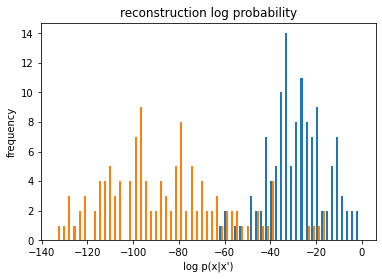

In [42]:
ax = plt.hist([X_train_VAE_scores.numpy()[y_train==0][:sum(y_train == 1)], X_train_VAE_scores.numpy()[y_train==1]], 60)
plt.title('reconstruction log probability')
plt.ylabel('frequency')
plt.xlabel("log p(x|x')")
plt.show()

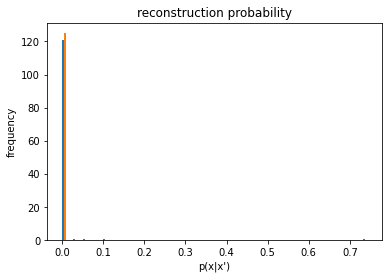

In [48]:
X_train_VAE_scores_probs = np.exp(X_train_VAE_scores.numpy())
ax = plt.hist([X_train_VAE_scores_probs[y_train==0][:sum(y_train == 1)], X_train_VAE_scores_probs[y_train==1]], 60)
plt.title('reconstruction probability')
plt.ylabel('frequency')
plt.xlabel("p(x|x')")
plt.show()

# Comparison with ADASYN

## PCA for Visualisation

In [80]:
from imblearn.over_sampling import ADASYN
from collections import Counter

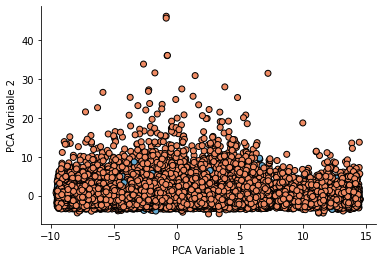

In [81]:
pca = PCA(n_components=2)
X_train_vis = pca.fit_transform(X_train_cleaned, y_train)
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
colors = ['#ef8a62' if v == 0 else '#67a9cf' if v == 1 else 'black' for v in y_train]
plt.scatter(X_train_vis[:, 0], X_train_vis[:, 1], c=colors, **kwarg_params)
plt.xlabel("PCA Variable 1")
plt.ylabel("PCA Variable 2")
sns.despine()

## ADASYN Up-sampling

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


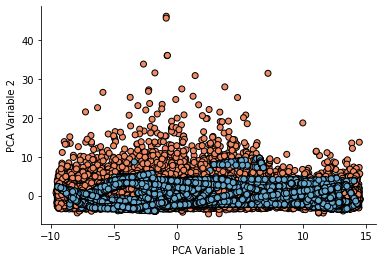

In [82]:
X_train_resampled, y_train_resampled = ADASYN(ratio={0:74875, 1:10000}, n_neighbors=4).fit_sample(X_train_cleaned, y_train)
# X_train_val_resampled, y_train_val_resampled = ADASYN(ratio={0:87353, 1:6000}, n_neighbors=3).fit_sample(X_train_val_cleaned, y_train_val)
X_train_resampled_vis = pca.transform(X_train_resampled)
colors = ['#ef8a62' if v == 0 else '#67a9cf' if v == 1 else 'black' for v in y_train_resampled]
plt.scatter(X_train_resampled_vis[:, 0], X_train_resampled_vis[:, 1], c=colors, **kwarg_params)
plt.xlabel("PCA Variable 1")
plt.ylabel("PCA Variable 2")
sns.despine()

In [83]:
print(Counter(y_train))
print(Counter(y_train_resampled))

Counter({0: 74875, 1: 125})
Counter({0: 74875, 1: 10002})


## Base Decision Tree Model

In [84]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=3).fit(X_train_cleaned,y_train)
y_pred_train = dt.predict_proba(X_train_cleaned)[:,1]
y_pred_val = dt.predict_proba(X_val_cleaned)[:,1]
y_pred_train_val = dt.predict_proba(X_train_val_cleaned)[:,1]
y_pred_test = dt.predict_proba(X_test_cleaned)[:,1]
all_results.add_results(y_pred_train, y_pred_val, y_pred_train_val, y_pred_test, "DT")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [85]:
from sklearn.tree import DecisionTreeClassifier
dt_resampled = DecisionTreeClassifier(max_depth=3).fit(X_train_resampled,y_train_resampled)
y_pred_train = dt_resampled.predict_proba(X_train_cleaned.to_numpy())[:,1]
y_pred_val = dt_resampled.predict_proba(X_val_cleaned.to_numpy())[:,1]
y_pred_train_val = dt_resampled.predict_proba(X_train_val_cleaned.to_numpy())[:,1]
y_pred_test = dt_resampled.predict_proba(X_test_cleaned.to_numpy())[:,1]
all_results.add_results(y_pred_train, y_pred_val, y_pred_train_val, y_pred_test, "DT-ADASYN")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [86]:
all_results.train_res

,AUC,AUC PRC,F1
PCA,0.947501,0.189318,0.352941
AE,0.956983,0.380441,0.404181
VAE,0.956978,0.402697,0.528926
DT,0.919834,0.733435,0.805310
DT-ADASYN,0.982173,0.385118,0.589595


In [87]:
all_results.val_res

,AUC,AUC PRC,F1
PCA,0.955023,0.206501,0.450000
AE,0.968501,0.360957,0.514286
VAE,0.969590,0.384541,0.521739
DT,0.931612,0.720967,0.769231
DT-ADASYN,0.930569,0.410616,0.612903


In [88]:
all_results.test_res

,AUC,AUC PRC,F1
PCA,0.973450,0.171445,0.160000
AE,0.977295,0.426893,0.380952
VAE,0.995166,0.366945,0.540541
DT,0.964111,0.761495,0.814815
DT-ADASYN,0.951966,0.309604,0.490566
